In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Fetch Dataset 

In [3]:
from SCFInitialGuess.utilities.dataset import ScreenedData

target = "P"

data = ScreenedData(r_max=10)

data.include(data_path = "../../dataset/MethanT/", postfix = "MethanT", target=target)
data.include(data_path = "../../dataset/MethanT2/", postfix = "MethanT2", target=target)
data.include(data_path = "../../dataset/MethanT3/", postfix = "MethanT3", target=target)
data.include(data_path = "../../dataset/MethanT4/", postfix = "MethanT4", target=target)

data.include(data_path = "../../dataset/EthanT/",  postfix = "EthanT", target=target)
data.include(data_path = "../../dataset/EthanT2/", postfix = "EthanT2", target=target)
data.include(data_path = "../../dataset/EthanT3/", postfix = "EthanT3", target=target)
data.include(data_path = "../../dataset/EthanT4/",  postfix = "EthanT4", target=target)
data.include(data_path = "../../dataset/EthanT5/",  postfix = "EthanT5", target=target)
data.include(data_path = "../../dataset/EthanT6/",  postfix = "EthanT6", target=target)

data.include(data_path = "../../dataset/EthenT/",  postfix = "EthenT", target=target)
data.include(data_path = "../../dataset/EthenT2/", postfix = "EthenT2", target=target)
data.include(data_path = "../../dataset/EthenT3/", postfix = "EthenT3", target=target)
data.include(data_path = "../../dataset/EthenT4/",  postfix = "EthenT4", target=target)
data.include(data_path = "../../dataset/EthenT5/",  postfix = "EthenT5", target=target)
data.include(data_path = "../../dataset/EthenT6/",  postfix = "EthenT6", target=target)


data.include(data_path = "../../dataset/EthinT/",  postfix = "EthinT", target=target)
data.include(data_path = "../../dataset/EthinT2/", postfix = "EthinT2", target=target)
data.include(data_path = "../../dataset/EthinT3/", postfix = "EthinT3", target=target)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

In [4]:
basis = "6-311++g**"
model_path="../../models/DescriptorH/" + target + "/"

# Descriptor 

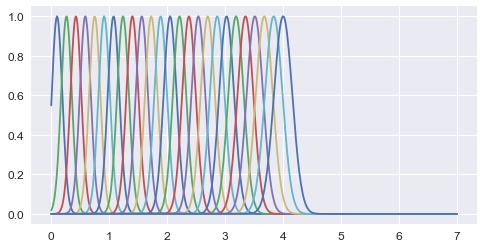

In [85]:
from SCFInitialGuess.descriptors.models import make_uniform 
from SCFInitialGuess.descriptors.utilities import plot_normal_model

# unif -5
#model = make_uniform(5, 5, eta_max=10, eta_min=1)

#unif-25
model = make_uniform(25, 5, eta_max=60, eta_min=20)

#model = make_uniform(n=50, R_c=5, eta_min=100, eta_max=30)
plot_normal_model(model, np.linspace(0, 7, 500))

In [86]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import RADIAL_GAUSSIAN_MODELS, make_uniform
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, SPHAngularDescriptor
    
import pickle

descriptor = AtomicNumberWeighted(
    #Gaussians(*RADIAL_GAUSSIAN_MODELS["Man"]),
    #Gaussians(*make_uniform(150, eta_max=200, eta_min=30)),
    Gaussians(*model),
    SPHAngularDescriptor(3),
    BehlerCutoff1(5)
)

pickle.dump(descriptor, open(model_path + "descriptor.dump", "wb"))

descriptor.radial_descriptor.number_of_descriptors, descriptor.angular_descriptor.number_of_descriptors, descriptor.number_of_descriptors

(25, 32, 57)

In [87]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset
index=200
f = lambda x: x#(x[0][:index], x[0][index:(2*index)], x[2])

dataset = make_center_block_dataset(
    descriptor,
    data.molecules,
    data.T,
    "H"
)

np.save(model_path + "normalisation.npy", (dataset.x_mean, dataset.x_std))


In [88]:
np.mean(dataset.testing[1][0])

0.018127005714004826

In [89]:
len(dataset.training[0]), len(dataset.validation[0]), len(dataset.testing[0]), 

(27932, 7012, 8794)

In [90]:
from SCFInitialGuess.utilities.dataset import AbstractDataset

x_train = AbstractDataset.denormalize(dataset.training[0], dataset.x_mean, dataset.x_std)
y_train = dataset.training[1]
np.mean(x_train[0] - x_train[-1])

0.10075986514199099

## Autocorrelation 

In [91]:
dataset.training[0].shape

(27932, 57)

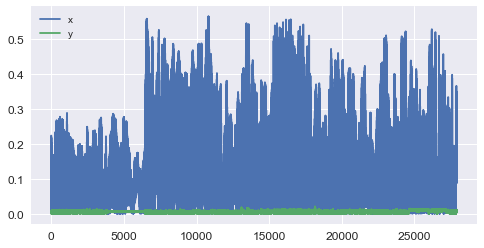

In [92]:

plt.plot(abs(np.mean(x_train[0] - x_train[1:], 1)), label="x")
plt.plot(abs(np.mean(y_train[0] - y_train[1:], 1)), label="y")

plt.legend()

## Variance

In [93]:
np.var(x_train, 0).shape

(57,)

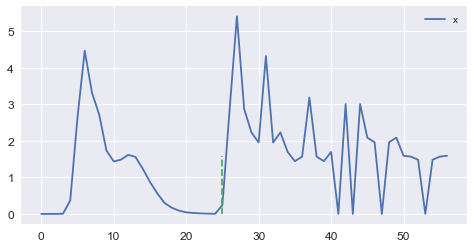

In [94]:
offset=0
plt.plot(np.var(x_train, 0)[offset:], label="x")
plt.plot([descriptor.radial_descriptor.number_of_descriptors - offset]*2, [1e-3, 1.6], "--")

plt.legend()

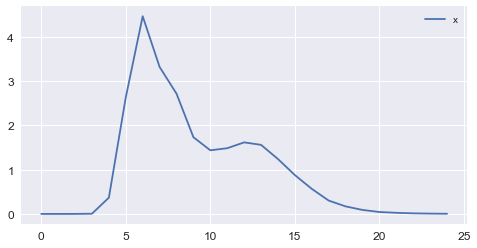

In [95]:
offset=0
plt.plot(np.var(x_train, 0)[offset:descriptor.radial_descriptor.number_of_descriptors], label="x")

plt.legend()

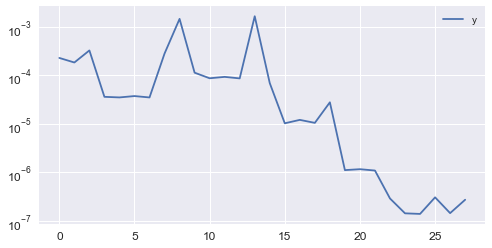

In [96]:
plt.semilogy(np.var(y_train, 0), label="y")
plt.legend()

# Average 

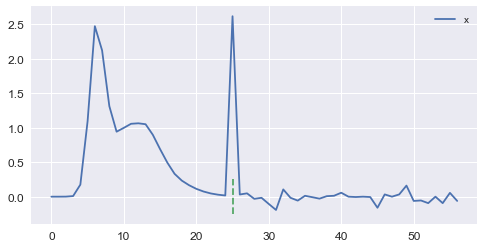

In [97]:
plt.plot(np.mean(x_train, 0), label="x")
plt.plot([descriptor.radial_descriptor.number_of_descriptors]*2, [-0.25, 0.25], "--")

plt.legend()

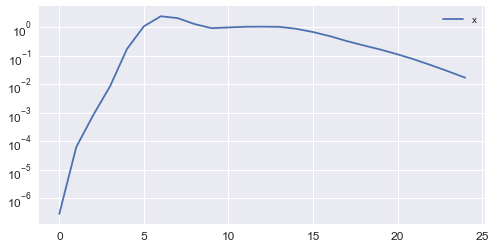

In [98]:
n_radial = descriptor.radial_descriptor.number_of_descriptors

plt.semilogy(np.mean(x_train, 0)[:n_radial], label="x")
#plt.plot([n_radial]*2, [-0.25, 0.25], "--")

plt.legend()

# Network Stuff 

In [99]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(5e-3)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mse']
    )
    
    return model



In [100]:

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-8, 
    patience=20, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=2, 
    min_lr=1e-10
)


epochs = 1000


def train_model(model, dataset, filepath, learning_rate=1e-4, log_dir="./logs"):

    
    tensorboard = keras.callbacks.TensorBoard(
        log_dir=log_dir, 
        histogram_freq=0, 
        batch_size=32, 
        #update_freq='epoch'
    )
    
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_mean_squared_error', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto', 
        period=1
    )
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    train, validation = [], []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                checkpoint,
                tensorboard
            ]
        )
            
        
        #error.append(model.evaluate(
        #    dataset.testing[0], 
        #    dataset.testing[1], 
        #    verbose=1
        #)[1])
    
    return error
    

# Actucal training 

In [101]:
len(dataset.training[0]), len(dataset.validation[0]), len(dataset.testing[0]), 

(27932, 7012, 8794)

In [102]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS


species = "H"

dim = N_BASIS[basis][species]
dim_triu = dim * (dim + 1) // 2


In [103]:
descriptor.number_of_descriptors, dim_triu

(57, 28)

In [104]:
structure = [50, 50]

In [105]:
keras.backend.clear_session()

In [106]:
model = make_model(
    structure=structure,
    input_dim=descriptor.number_of_descriptors,
    output_dim=dim_triu,
    
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2900      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 28)                1428      
Total params: 6,878
Trainable params: 6,878
Non-trainable params: 0
_________________________________________________________________


In [107]:
i =0
name_folder = "H_" + target  + ".h5"
name = target + "/500-10"

Train on 27932 samples, validate on 7012 samples
Epoch 1/1000
27932/27932 [==============================] - 2s 78us/step - loss: 4.0152e-04 - mean_squared_error: 3.2417e-04 - val_loss: 1.1239e-04 - val_mean_squared_error: 9.9044e-05

Epoch 00001: val_mean_squared_error improved from inf to 0.00010, saving model to ../../models/DescriptorH/P/H_P.h5
Epoch 2/1000
27932/27932 [==============================] - 2s 72us/step - loss: 1.0346e-04 - mean_squared_error: 9.1881e-05 - val_loss: 1.0399e-04 - val_mean_squared_error: 9.2649e-05

Epoch 00002: val_mean_squared_error improved from 0.00010 to 0.00009, saving model to ../../models/DescriptorH/P/H_P.h5
Epoch 3/1000
27932/27932 [==============================] - 2s 72us/step - loss: 9.4721e-05 - mean_squared_error: 8.5275e-05 - val_loss: 9.8703e-05 - val_mean_squared_error: 8.9939e-05

Epoch 00003: val_mean_squared_error improved from 0.00009 to 0.00009, saving model to ../../models/DescriptorH/P/H_P.h5
Epoch 4/1000
27932/27932 [===========


Epoch 00029: val_mean_squared_error did not improve from 0.00007
Epoch 30/1000
27932/27932 [==============================] - 3s 109us/step - loss: 6.6175e-05 - mean_squared_error: 6.1443e-05 - val_loss: 7.5608e-05 - val_mean_squared_error: 7.0881e-05

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00030: val_mean_squared_error did not improve from 0.00007
Epoch 31/1000
27932/27932 [==============================] - 3s 91us/step - loss: 6.6134e-05 - mean_squared_error: 6.1406e-05 - val_loss: 7.5608e-05 - val_mean_squared_error: 7.0881e-05

Epoch 00031: val_mean_squared_error did not improve from 0.00007
Epoch 32/1000
27932/27932 [==============================] - 2s 84us/step - loss: 6.6131e-05 - mean_squared_error: 6.1401e-05 - val_loss: 7.5617e-05 - val_mean_squared_error: 7.0889e-05

Epoch 00032: val_mean_squared_error did not improve from 0.00007
Epoch 33/1000
27932/27932 [==============================] - 5s 162us/step - loss: 6.6130e-05 - 

27932/27932 [==============================] - 3s 99us/step - loss: 6.3101e-05 - mean_squared_error: 5.8702e-05 - val_loss: 7.2571e-05 - val_mean_squared_error: 6.8167e-05

Epoch 00013: val_mean_squared_error did not improve from 0.00007
Epoch 14/1000
27932/27932 [==============================] - 2s 80us/step - loss: 6.3093e-05 - mean_squared_error: 5.8697e-05 - val_loss: 7.2585e-05 - val_mean_squared_error: 6.8177e-05

Epoch 00014: val_mean_squared_error did not improve from 0.00007
Epoch 15/1000
27932/27932 [==============================] - 3s 91us/step - loss: 6.3082e-05 - mean_squared_error: 5.8685e-05 - val_loss: 7.2655e-05 - val_mean_squared_error: 6.8244e-05

Epoch 00015: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00015: val_mean_squared_error did not improve from 0.00007
Epoch 16/1000
27932/27932 [==============================] - 3s 100us/step - loss: 6.3040e-05 - mean_squared_error: 5.8632e-05 - val_loss: 7.2612e-05 - val_mean_squared_error: 6


Epoch 00013: val_mean_squared_error did not improve from 0.00007
Epoch 14/1000
27932/27932 [==============================] - 4s 140us/step - loss: 6.0586e-05 - mean_squared_error: 5.6354e-05 - val_loss: 7.0519e-05 - val_mean_squared_error: 6.6265e-05

Epoch 00014: val_mean_squared_error did not improve from 0.00007
Epoch 15/1000
27932/27932 [==============================] - 4s 127us/step - loss: 6.0581e-05 - mean_squared_error: 5.6327e-05 - val_loss: 7.0363e-05 - val_mean_squared_error: 6.6129e-05

Epoch 00015: val_mean_squared_error did not improve from 0.00007
Epoch 16/1000
27932/27932 [==============================] - 4s 138us/step - loss: 6.0576e-05 - mean_squared_error: 5.6329e-05 - val_loss: 7.0289e-05 - val_mean_squared_error: 6.6043e-05

Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00016: val_mean_squared_error did not improve from 0.00007
Epoch 17/1000
27932/27932 [==============================] - 6s 216us/step - loss: 6.0530e-05 


Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00013: val_mean_squared_error did not improve from 0.00007
Epoch 14/1000
27932/27932 [==============================] - 4s 126us/step - loss: 5.9234e-05 - mean_squared_error: 5.5035e-05 - val_loss: 6.9463e-05 - val_mean_squared_error: 6.5264e-05

Epoch 00014: val_mean_squared_error did not improve from 0.00007
Epoch 15/1000
27932/27932 [==============================] - 5s 180us/step - loss: 5.9229e-05 - mean_squared_error: 5.5030e-05 - val_loss: 6.9454e-05 - val_mean_squared_error: 6.5255e-05

Epoch 00015: val_mean_squared_error did not improve from 0.00007
Epoch 16/1000
27932/27932 [==============================] - 6s 212us/step - loss: 5.9227e-05 - mean_squared_error: 5.5029e-05 - val_loss: 6.9437e-05 - val_mean_squared_error: 6.5238e-05

Epoch 00016: val_mean_squared_error did not improve from 0.00007
Epoch 17/1000
27932/27932 [==============================] - 4s 147us/step - loss: 5.9226e-05 

27932/27932 [==============================] - 6s 222us/step - loss: 5.7921e-05 - mean_squared_error: 5.3682e-05 - val_loss: 6.8453e-05 - val_mean_squared_error: 6.4213e-05

Epoch 00011: val_mean_squared_error did not improve from 0.00006
Epoch 12/1000
27932/27932 [==============================] - 5s 174us/step - loss: 5.7916e-05 - mean_squared_error: 5.3668e-05 - val_loss: 6.8543e-05 - val_mean_squared_error: 6.4282e-05

Epoch 00012: val_mean_squared_error did not improve from 0.00006
Epoch 13/1000
27932/27932 [==============================] - 7s 242us/step - loss: 5.7906e-05 - mean_squared_error: 5.3646e-05 - val_loss: 6.8506e-05 - val_mean_squared_error: 6.4258e-05

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00013: val_mean_squared_error did not improve from 0.00006
Epoch 14/1000
27932/27932 [==============================] - 8s 271us/step - loss: 5.7861e-05 - mean_squared_error: 5.3614e-05 - val_loss: 6.8493e-05 - val_mean_squared_error


Epoch 00012: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00012: val_mean_squared_error did not improve from 0.00006
Epoch 13/1000
27932/27932 [==============================] - 5s 181us/step - loss: 5.6819e-05 - mean_squared_error: 5.2535e-05 - val_loss: 6.7897e-05 - val_mean_squared_error: 6.3610e-05

Epoch 00013: val_mean_squared_error did not improve from 0.00006
Epoch 14/1000
27932/27932 [==============================] - 4s 155us/step - loss: 5.6815e-05 - mean_squared_error: 5.2529e-05 - val_loss: 6.7881e-05 - val_mean_squared_error: 6.3594e-05

Epoch 00014: val_mean_squared_error did not improve from 0.00006
Epoch 15/1000
27932/27932 [==============================] - 5s 168us/step - loss: 5.6813e-05 - mean_squared_error: 5.2527e-05 - val_loss: 6.7863e-05 - val_mean_squared_error: 6.3576e-05

Epoch 00015: val_mean_squared_error did not improve from 0.00006
Epoch 16/1000
27932/27932 [==============================] - 6s 201us/step - loss: 5.6812e-05 

KeyboardInterrupt: 

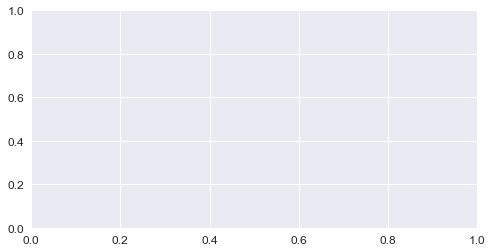

In [108]:
i+=1
train_model(
    model, 
    dataset, 
    model_path + name_folder,
    learning_rate=1e-4,
    log_dir="./logs/H/" + name + "_" + "x".join(list(map(str, structure))) + "_" + str(i)
)